# Code for creating a dataset from a list of chips

Adapted from Sara King's HuggingFaceDatasetCreation in data processing

to be done after identifying chips using chips_exclude.ipynb

mjf 05/23/2025

Import packages

In [13]:
from PIL import Image as PILImage
import os
#import evaluate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
#from patchify import patchify
from datasets import load_dataset, DatasetDict, Dataset, Image as HFImage, Dataset, Features, Array3D, Array2D
from sklearn.model_selection import train_test_split
from osgeo import gdal
import glob

Login to hugging face if needed

In [14]:
# import huggingface_hub

# huggingface_hub.login(token = 'insert your token here')

In [15]:
from matplotlib.colors import LinearSegmentedColormap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

Create your lists of training images, validation images, and test images.

In [16]:
path = '/explore/nobackup/people/mfrost2/projects/boreal_chm_dino/training_all_ak_100k_both.csv'
data = "nrg"
band_min = 0

# green_min = -4453
# red_min = -9998
# nir_min = -2220

# blue_max = 5681
green_max = 5387
red_max = 5893
nir_max = 7142

start = path.find("training_all_") + len("training_all_")
end = path.find(".csv")
desc = path[start:end]
desc = "maxmin_" + desc + "_" + data
print(desc) 

df = pd.read_csv(path)
df = df[~df['filename'].isna()]

#Add images fn column
df['image_fn'] = df['filename'].str.replace('labels', 'images')
df = df.rename(columns={'filename': 'label_fn'})

df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

image_paths_train = list(df_train['image_fn'])
label_paths_train = list(df_train['label_fn'])

image_paths_test = list(df_test['image_fn'])
label_paths_test = list(df_test['label_fn'])

maxmin_ak_100k_both_nrg


In [17]:
len(image_paths_train)

80000

In [18]:
## Double checking matching numpy chip names
# Print each value on a separate line
for i, path in enumerate(label_paths_train[:9]):
    print(f"{i}: {path}")
for i, path in enumerate(image_paths_train[:9]):
    print(f"{i}: {path}")

0: /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/chip_WV02_20150802_M1BS_1030010047ADDD00_CHM_AK_IFSAR_CHM_02574_v20231006.npy
1: /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/chip_WV02_20110815_M1BS_103001000D5B3F00_CHM_AK_IFSAR_CHM_00950_v20231006.npy
2: /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/chip_WV02_20190820_M1BS_10300100954DE000_CHM_AK_IFSAR_CHM_01014_v20231006.npy
3: /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/chip_WV02_20160827_M1BS_103001005CAE7900_CHM_infrastructure_2011_26906_01974_v20231006.npy
4: /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/chip_WV02_20190709_M1BS_1030010095131900_CHM_AK_IFSAR_CHM_02283_v20231006.npy
5: /explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/chip_WV02_20180

# Visualize train

In [19]:
# Convert the WKT column to geometry objects
gdf = gpd.GeoDataFrame(df_train, geometry=gpd.GeoSeries.from_wkt(df_train['geometry']), crs="EPSG:3338")
gdf['row_number'] = np.arange(0, len(gdf))
#gdf.to_file('training_gdf_fairbanks.gpkg', driver='GPKG')

In [20]:
gdf.groupName.unique()

array(['ifsar_78_train_v20231006', 'lidar_78_train_v20231006',
       'ifsar_78_ocean_train_v20231006'], dtype=object)

In [21]:
# subset = gdf[gdf['groupName'] == 'ifsar_78_train_v20231006'] 
# print(subset.shape)
gdf[:500].explore(column='max', cmap='Spectral_r', tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="Esri")

In [22]:
# gdf['groupName'].unique()

chip_WV02_20190830_M1BS_10300100966ED400_CHM_fairbanks_ql2_2017_04030_v20231006


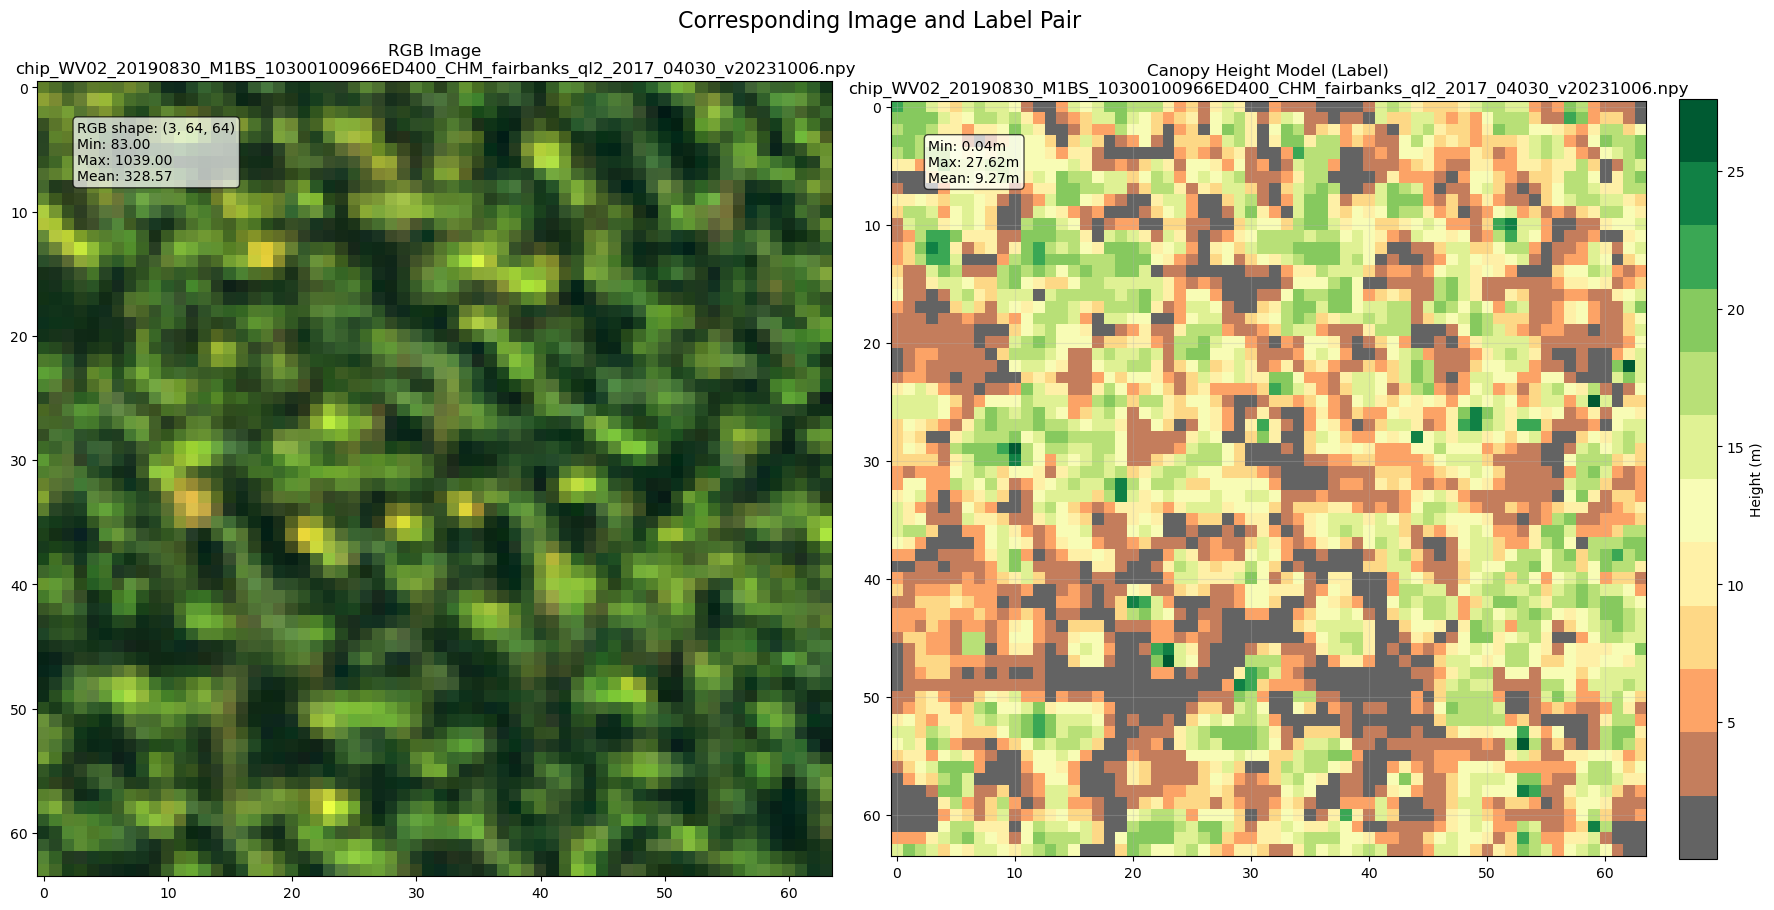

In [23]:
row = 500

print(gdf['chipName'].iloc[row])
# Visualize the RGB image and labels

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# FIRST IMAGE (LEFT) - RGB visualization
file_path = image_paths_train[row]
data = np.load(file_path)
rgb_array = data[:3, :, :]
image = np.transpose(rgb_array, (1, 2, 0))
rgb_image = image[:, :, [2, 1, 0]] #(Band 1 = Blue, 2 = Green, 3 = Red, 4 = NIR
image_normalized = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

# Get filename for display
rgb_filename = os.path.basename(file_path)

# Display the RGB image on the LEFT subplot
im1 = axes[0].imshow(image_normalized)
axes[0].set_title(f'RGB Image\n{rgb_filename}', fontsize=12)
axes[0].axis('on')

# Calculate statistics for annotation
min_rgb = np.min(rgb_array)
max_rgb = np.max(rgb_array)
mean_rgb = np.mean(rgb_array)

# Add text annotation with statistics
stats_text = f"RGB shape: {rgb_array.shape}\nMin: {min_rgb:.2f}\nMax: {max_rgb:.2f}\nMean: {mean_rgb:.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
axes[0].text(0.05, 0.95, stats_text, transform=axes[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# SECOND IMAGE (RIGHT) - Label visualization
file_path = label_paths_train[row]
data = np.load(file_path)
reshaped_data = data[0]

# Get filename for display
label_filename = os.path.basename(file_path)

# Display the label image on the RIGHT subplot
im2 = axes[1].imshow(reshaped_data, cmap=forest_ht_cmap)
axes[1].set_title(f'Canopy Height Model (Label)\n{label_filename}', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Add colorbar for the label image
cbar = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label('Height (m)')

# Calculate statistics for annotation
min_val = np.min(reshaped_data)
max_val = np.max(reshaped_data)
mean_val = np.mean(reshaped_data)

# Add text annotation with statistics
stats_text = f"Min: {min_val:.2f}m\nMax: {max_val:.2f}m\nMean: {mean_val:.2f}m"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
axes[1].text(0.05, 0.95, stats_text, transform=axes[1].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Check if the paths are the same except for 'labels' vs 'images'
label_dir = os.path.dirname(label_paths_train[0])
image_dir = os.path.dirname(image_paths_train[0])
if label_dir.replace('labels', '') == image_dir.replace('images', ''):
    fig.suptitle("Corresponding Image and Label Pair", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the suptitle
plt.show()

# # Print statistics to console
# print("RGB IMAGE STATS:")
# print(f"Shape: {rgb_array.shape}")
# print(f"Min value: {min_rgb}")
# print(f"Max value: {max_rgb}")
# print(f"Mean value: {mean_rgb}")

# print("\nLABEL IMAGE STATS:")
# print(f"Shape: {reshaped_data.shape}")
# print(f"Min value: {min_val}")
# print(f"Max value: {max_val}")
# print(f"Mean value: {mean_val}")

This set of functions tiles the images and masks into your specified patch size, removes the any pairs of images and masks where the masks are "empty" (only contain 0 or 1 values), and saves the images and masks as lists of numpy arrays. 

In [24]:
def open_image_and_label(image_path, label_path):
    # Load the image and mask
    # print(image_path)
    # print(label_path)
    image = np.load(image_path)
    label = np.load(label_path)
    
    image = np.transpose(image, (1, 2, 0)) #change to shape 64 x 64 x 4

    # Ensure masks are 2D for simplicity
    if len(label.shape) > 2 and label.shape[0] == 1:
        label = label[0]
    
    # print(f"Image shape: {image.shape}")
    # print(f"Label shape: {label.shape}")
    
    return image, label

## Put it all together
def process_and_save_images(image_paths, label_paths):
    all_images = []
    all_labels = []

    for img_path, label_path in zip(image_paths, label_paths):
        images, labels = open_image_and_label(img_path, label_path)
        #print(images.shape, labels.shape)
        
        # append
        all_images.append(images)
        all_labels.append(labels)
        
    
    # Stack all valid image and mask patches
    all_images = np.stack(all_images)
    print(all_images.shape)
    #rgb_images = all_images[...,[2, 1, 0]]
    nrg_images = all_images[...,[3, 2, 1]]
    print(nrg_images.shape)
    
    all_labels = np.stack(all_labels)
    all_labels = all_labels.astype(np.float32)
    print(all_labels.mean())
    
    ########### check for empty arrays # Not sure this matters
    count = 0
    for i, arr in enumerate(all_labels):
        if np.max(arr) == 0:
            count += 1
    print("empty arrays: ",count)
    
    return nrg_images, all_labels

    # Filter out empty masks
    valid_indices = [i for i, mask in enumerate(all_labels) if mask.max() != 0]
    filtered_images = all_images[valid_indices]
    filtered_masks = all_masks[valid_indices]

#process_and_save_images(image_paths_train[:5], label_paths_train[:5])

train_images, train_labels = process_and_save_images(image_paths_train, label_paths_train)
test_images, test_labels = process_and_save_images(image_paths_test, label_paths_test)

(80000, 64, 64, 4)
(80000, 64, 64, 3)
2.6301377
empty arrays:  0
(20000, 64, 64, 4)
(20000, 64, 64, 3)
2.6716518
empty arrays:  0


In [25]:
train_labels.dtype

dtype('float32')

In [26]:
train_images.shape

(80000, 64, 64, 3)

In [27]:
print("TRAIN IMAGE STATISTICS:")
print(f"Train images shape: {train_images.shape}")
for channel in range(3):
    channel_data = train_images[:, :, :, channel]
    print(f"Channel {channel}:")
    print(f"  Min: {channel_data.min():.6f}")
    print(f"  Max: {channel_data.max():.6f}")
    print(f"  Mean: {channel_data.mean():.6f}")
    print(f"  Std: {channel_data.std():.6f}")
    print(f"  Median: {np.median(channel_data):.6f}")
    print()

print("TEST IMAGE STATISTICS:")
print(f"Test images shape: {test_images.shape}")
for channel in range(3):
    channel_data = test_images[:, :, :, channel]
    print(f"Channel {channel}:")
    print(f"  Min: {channel_data.min():.6f}")
    print(f"  Max: {channel_data.max():.6f}")
    print(f"  Mean: {channel_data.mean():.6f}")
    print(f"  Std: {channel_data.std():.6f}")
    print(f"  Median: {np.median(channel_data):.6f}")
    print()

print("COMPARISON:")
for channel in range(3):
    train_mean = train_images[:, :, :, channel].mean()
    test_mean = test_images[:, :, :, channel].mean()
    train_std = train_images[:, :, :, channel].std()
    test_std = test_images[:, :, :, channel].std()
    
    print(f"Channel {channel}:")
    print(f"  Mean ratio (test/train): {test_mean/train_mean:.3f}")
    print(f"  Std ratio (test/train): {test_std/train_std:.3f}")

TRAIN IMAGE STATISTICS:
Train images shape: (80000, 64, 64, 3)
Channel 0:
  Min: -1730.000000
  Max: 11944.000000
  Mean: 2440.836426
  Std: 971.695923
  Median: 2408.000000

Channel 1:
  Min: -1507.000000
  Max: 10277.000000
  Mean: 478.916504
  Std: 246.585770
  Median: 422.000000

Channel 2:
  Min: -938.000000
  Max: 8399.000000
  Mean: 540.545715
  Std: 184.307007
  Median: 517.000000

TEST IMAGE STATISTICS:
Test images shape: (20000, 64, 64, 3)
Channel 0:
  Min: -1779.000000
  Max: 9882.000000
  Mean: 2436.658447
  Std: 965.546143
  Median: 2405.000000

Channel 1:
  Min: -1631.000000
  Max: 8849.000000
  Mean: 478.112396
  Std: 244.418411
  Median: 422.000000

Channel 2:
  Min: -568.000000
  Max: 7447.000000
  Mean: 539.593201
  Std: 182.104904
  Median: 516.000000

COMPARISON:
Channel 0:
  Mean ratio (test/train): 0.998
  Std ratio (test/train): 0.994
Channel 1:
  Mean ratio (test/train): 0.998
  Std ratio (test/train): 0.991
Channel 2:
  Mean ratio (test/train): 0.998
  Std rati

In [29]:
def scale_channels_to_1_combined(train_array, test_array):
    """
    Scale train and test arrays using the SAME scaling parameters.
    """
    # Combine arrays to get global min/max
    combined_array = np.concatenate([train_array, test_array], axis=0)
    
    original_shape_train = train_array.shape
    original_shape_test = test_array.shape
    num_channels = original_shape_train[3]
    
    # Create output arrays
    scaled_train = np.zeros(original_shape_train, dtype=np.float32)
    scaled_test = np.zeros(original_shape_test, dtype=np.float32)
    
    # Process each channel using COMBINED statistics
    for c in range(num_channels):
        # Get min and max from COMBINED data
        combined_channel = combined_array[:, :, :, c]
        # min_val = np.nanmin(combined_channel)
        #min_val = 0
        # max_val = np.nanmax(combined_channel)
        if c == 0:
            min_val = 0
            max_val = nir_max
        elif c == 1:
            min_val = 0
            max_val = red_max
        else:
            min_val = 0
            max_val = green_max
        
        print(f"Channel {c}: Global min={min_val:.2f}, max={max_val:.2f}")
        
        if max_val > min_val:
            # Scale train data
            train_channel = train_array[:, :, :, c]
            scaled_train_channel = (train_channel - min_val) / (max_val - min_val)
            scaled_train_channel = np.clip(scaled_train_channel, 0, 1)
            scaled_train[:, :, :, c] = scaled_train_channel.astype(np.float32)
            
            # Scale test data using SAME parameters
            test_channel = test_array[:, :, :, c]
            scaled_test_channel = (test_channel - min_val) / (max_val - min_val)
            scaled_test_channel = np.clip(scaled_test_channel, 0, 1)
            scaled_test[:, :, :, c] = scaled_test_channel.astype(np.float32)
        else:
            scaled_train[:, :, :, c] = 1 if min_val > 0 else 0
            scaled_test[:, :, :, c] = 1 if min_val > 0 else 0
    
    return scaled_train, scaled_test

# Usage:
scaled_train_images, scaled_test_images = scale_channels_to_1_combined(train_images, test_images)

Channel 0: Global min=0.00, max=7142.00
Channel 1: Global min=0.00, max=5893.00
Channel 2: Global min=0.00, max=5387.00


In [ ]:
print("TRAIN IMAGE STATISTICS:")
print(f"Train images shape: {scaled_train_images.shape}")
for channel in range(3):
    channel_data = scaled_train_images[:, :, :, channel]
    print(f"Channel {channel}:")
    print(f"  Min: {channel_data.min():.6f}")
    print(f"  Max: {channel_data.max():.6f}")
    print(f"  Mean: {channel_data.mean():.6f}")
    print(f"  Std: {channel_data.std():.6f}")
    print(f"  Median: {np.median(channel_data):.6f}")
    print()

print("TEST IMAGE STATISTICS:")
print(f"Test images shape: {scaled_test_images.shape}")
for channel in range(3):
    channel_data = scaled_test_images[:, :, :, channel]
    print(f"Channel {channel}:")
    print(f"  Min: {channel_data.min():.6f}")
    print(f"  Max: {channel_data.max():.6f}")
    print(f"  Mean: {channel_data.mean():.6f}")
    print(f"  Std: {channel_data.std():.6f}")
    print(f"  Median: {np.median(channel_data):.6f}")
    print()

print("COMPARISON:")
for channel in range(3):
    train_mean = train_images[:, :, :, channel].mean()
    test_mean = test_images[:, :, :, channel].mean()
    train_std = train_images[:, :, :, channel].std()
    test_std = test_images[:, :, :, channel].std()
    
    print(f"Channel {channel}:")
    print(f"  Mean ratio (test/train): {test_mean/train_mean:.3f}")
    print(f"  Std ratio (test/train): {test_std/train_std:.3f}")

In [ ]:
print(train_images[0].max())
print(scaled_train_images[:,:,:,1].max())
print(test_labels.shape)

Function to turn the lists of image and mask arrays into a training and test dataset.

In [ ]:
def create_dataset(image_arrays, label_arrays):
    """
    Create a Hugging Face dataset from image arrays and label arrays.
    
    Args:
        image_arrays: List of numpy arrays with shape (64, 64, 3)
        label_arrays: List of numpy arrays with shape (64, 64)
        
    Returns:
        Hugging Face Dataset
    """
    # Ensure all inputs are proper numpy arrays with correct dtype
    image_list = []
    label_list = []
    
    for i, (img_array, label_array) in enumerate(zip(image_arrays, label_arrays)):
        # Convert to numpy arrays if they aren't already
        if not isinstance(img_array, np.ndarray):
            img_array = np.array(img_array, dtype=np.float32)
        else:
            # Ensure correct dtype
            img_array = img_array.astype(np.float32)
            
        if not isinstance(label_array, np.ndarray):
            label_array = np.array(label_array, dtype=np.float32)
        else:
            # Ensure correct dtype
            label_array = label_array.astype(np.float32)
        
        # Ensure correct shapes
        if img_array.shape != (64, 64, 3):
            print(f"Warning: Image at index {i} has shape {img_array.shape}, expected (64, 64, 3)")
            # Try to fix common shape issues
            if len(img_array.shape) == 2:  # Grayscale
                img_array = np.stack([img_array] * 3, axis=-1)
            elif img_array.shape == (3, 64, 64):  # Transposed
                img_array = np.transpose(img_array, (1, 2, 0))
                
        if label_array.shape != (64, 64):
            print(f"Warning: Label at index {i} has shape {label_array.shape}, expected (64, 64)")
            # Try to fix common shape issues
            if len(label_array.shape) > 2:
                label_array = np.squeeze(label_array)
        
        image_list.append(img_array)
        label_list.append(label_array)
    
    # Create the dictionary with the properly prepared arrays
    data_dict = {
        'image': image_list,
        'chm': label_list,
    }
    
    # Define features
    features = Features({
        'image': Array3D(shape=(64, 64, 3), dtype='float32'),
        'chm': Array2D(shape=(64, 64), dtype='float32'),
    })
    
    # Create and verify the dataset
    dataset = Dataset.from_dict(data_dict, features=features)
    
    # Verify that the dataset was created correctly
    print(f"Dataset created with {len(dataset)} samples")
    print(f"Features: {dataset.features}")
    
    # Verify the first sample format
    first_sample = dataset[0]
    print(f"First sample image type: {type(first_sample['image'])}")
    print(f"First sample image shape: {np.array(first_sample['image']).shape}")
    print(f"First sample chm type: {type(first_sample['chm'])}")
    print(f"First sample chm shape: {np.array(first_sample['chm']).shape}")
    
    return dataset

In [ ]:
train_dataset = create_dataset(scaled_train_images, train_labels)
test_dataset = create_dataset(scaled_test_images, test_labels)

Compile your train and test dataset into a single huggingface formatted dataset. 

In [ ]:
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
  }
)

In [ ]:
dataset

Upload your dataset

In [23]:
# print("Raw train image stats (before transforms) - FULL DATASET:")
# raw_train_imgs = []
# for i in range(len(dataset['train'])):  # Process ALL training samples
#     raw_img = np.array(dataset['train'][i]['image'])  # Direct access to raw image
#     if len(raw_img.shape) == 3:  # Make sure it's [H, W, C]
#         raw_train_imgs.append(raw_img.reshape(-1, 3))  # Flatten to [pixels, channels]

# raw_train = np.concatenate(raw_train_imgs, axis=0)  # [all_pixels, 3]
# print("  Channel means:", [raw_train[:, i].mean() for i in range(3)])
# print("  Channel stds:", [raw_train[:, i].std() for i in range(3)])
# print("  Channel mins:", [raw_train[:, i].min() for i in range(3)])
# print("  Channel maxs:", [raw_train[:, i].max() for i in range(3)])
# print("  Channel medians:", [np.median(raw_train[:, i]) for i in range(3)])

# print("\nRaw validation image stats (before transforms) - FULL DATASET:")
# raw_val_imgs = []
# for i in range(len(dataset['test'])):  # Process ALL validation samples
#     raw_img = np.array(dataset['test'][i]['image'])
#     if len(raw_img.shape) == 3:
#         raw_val_imgs.append(raw_img.reshape(-1, 3))

# raw_val = np.concatenate(raw_val_imgs, axis=0)
# print("  Channel means:", [raw_val[:, i].mean() for i in range(3)])
# print("  Channel stds:", [raw_val[:, i].std() for i in range(3)])
# print("  Channel mins:", [raw_val[:, i].min() for i in range(3)])
# print("  Channel maxs:", [raw_val[:, i].max() for i in range(3)])
# print("  Channel medians:", [np.median(raw_val[:, i]) for i in range(3)])

In [24]:
#dataset.push_to_hub('yourusername/yourdataset') #only for huggingface
# Save to disk
print(f"/explore/nobackup/people/mfrost2/projects/boreal_chm_dino/{desc}_dataset")
dataset.save_to_disk(f"/explore/nobackup/people/mfrost2/projects/boreal_chm_dino/{desc}_dataset")

/explore/nobackup/people/mfrost2/projects/boreal_chm_dino/maxmin_ak_50k_both_nrg_dataset


Saving the dataset (0/7 shards):   0%|          | 0/37974 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/9494 [00:00<?, ? examples/s]

test if your dataset is downloadable and view what info is contained in your dataset

In [25]:
from datasets import load_from_disk

dataset2 = load_from_disk(f"/explore/nobackup/people/mfrost2/projects/boreal_chm_dino/{desc}_dataset")

In [26]:
dataset2

DatasetDict({
    train: Dataset({
        features: ['image', 'chm'],
        num_rows: 37974
    })
    test: Dataset({
        features: ['image', 'chm'],
        num_rows: 9494
    })
})

In [30]:
print("Raw train image stats (before transforms) - FULL DATASET:")
raw_train_imgs = []
for i in range(len(dataset2['train'])):  # Process ALL training samples
    raw_img = np.array(dataset2['train'][i]['image'])  # Direct access to raw image
    if len(raw_img.shape) == 3:  # Make sure it's [H, W, C]
        raw_train_imgs.append(raw_img.reshape(-1, 3))  # Flatten to [pixels, channels]

raw_train = np.concatenate(raw_train_imgs, axis=0)  # [all_pixels, 3]
print("  Channel means:", [raw_train[:, i].mean() for i in range(3)])
print("  Channel stds:", [raw_train[:, i].std() for i in range(3)])
print("  Channel mins:", [raw_train[:, i].min() for i in range(3)])
print("  Channel maxs:", [raw_train[:, i].max() for i in range(3)])
print("  Channel medians:", [np.median(raw_train[:, i]) for i in range(3)])

print("\nRaw validation image stats (before transforms) - FULL DATASET:")
raw_val_imgs = []
for i in range(len(dataset2['test'])):  # Process ALL validation samples
    raw_img = np.array(dataset2['test'][i]['image'])
    if len(raw_img.shape) == 3:
        raw_val_imgs.append(raw_img.reshape(-1, 3))

raw_val = np.concatenate(raw_val_imgs, axis=0)
print("  Channel means:", [raw_val[:, i].mean() for i in range(3)])
print("  Channel stds:", [raw_val[:, i].std() for i in range(3)])
print("  Channel mins:", [raw_val[:, i].min() for i in range(3)])
print("  Channel maxs:", [raw_val[:, i].max() for i in range(3)])
print("  Channel medians:", [np.median(raw_val[:, i]) for i in range(3)])

Raw train image stats (before transforms) - FULL DATASET:


NameError: name 'dataset2' is not defined

In [31]:
## Get normalization statistics for the BGRI image deataset
# Calculate mean across all examples, height, and width (leaving only channel dimension)
def safe_channel_stats(array):
    """Safe calculation of channel statistics for large arrays."""
    n_channels = array.shape[-1]
    means = np.zeros(n_channels)
    stds = np.zeros(n_channels)
    
    for i in range(n_channels):
        channel_data = array[:, :, :, i].flatten()
        means[i] = channel_data.mean()
        stds[i] = channel_data.std()
    
    return means, stds

# Use this instead of numpy's multi-axis operations
mean_values, std_values = safe_channel_stats(scaled_train_images)

# Calculate max across the same dimensions
max_values = scaled_train_images.max(axis=(0, 1, 2))

# Calculate max across the same dimensions
min_values = scaled_train_images.min(axis=(0, 1, 2))

print("Mean values per channel:", mean_values)  # Shape will be (4,)
print("Standard deviation per channel:", std_values)  # Shape will be (4,)
print("Max values per channel:", max_values)  # Shape will be (4,)
print("Min values per channel:", min_values)  # Shape will be (4,)

np.save(f'numpy_stats/channel_means_{desc}_final.npy', mean_values)
np.save(f'numpy_stats/channel_stds_{desc}_final.npy', std_values)
np.save(f'numpy_stats/channel_maxes_{desc}_final.npy', max_values)
np.save(f'numpy_stats/channel_mins_{desc}_final.npy', min_values)

Mean values per channel: [0.34176117 0.08127703 0.10034456]
Standard deviation per channel: [0.13601232 0.04182002 0.03420006]
Max values per channel: [1. 1. 1.]
Min values per channel: [0. 0. 0.]


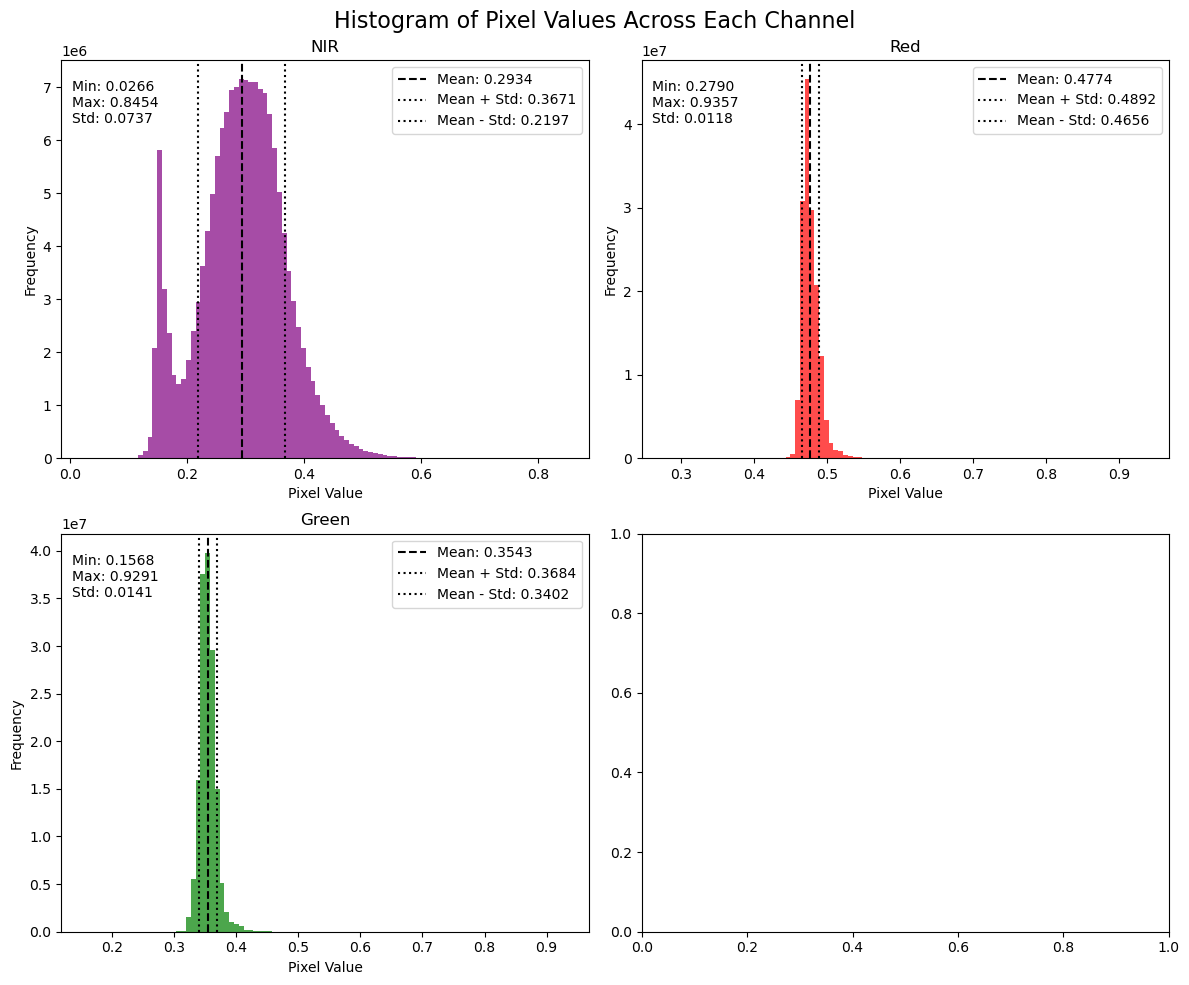

In [29]:
# Create a figure with 4 subplots (one for each channel) NRG
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

channel_names = ['NIR', 'Red', 'Green', 'Blue (not calc)']  # Replace with actual channel names if known
colors = ['purple', 'red', 'green', 'blue']  # Colors for each histogram

# Loop through each channel
for i in range(3):
    # Reshape data to get all values for this channel
    channel_data = scaled_train_images[:, :, :, i].flatten()
    
    # Calculate statistics for this channel
    mean_val = np.mean(channel_data)
    std_val = np.std(channel_data)
    min_val = np.min(channel_data)
    max_val = np.max(channel_data)
    
    # Create histogram
    axes[i].hist(channel_data, bins=100, alpha=0.7, color=colors[i])
    axes[i].set_title(f'{channel_names[i]}')
    axes[i].axvline(mean_val, color='k', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.4f}')
    axes[i].axvline(mean_val + std_val, color='k', linestyle='dotted', linewidth=1.5, label=f'Mean + Std: {mean_val + std_val:.4f}')
    axes[i].axvline(mean_val - std_val, color='k', linestyle='dotted', linewidth=1.5, label=f'Mean - Std: {mean_val - std_val:.4f}')
    axes[i].legend()
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
    axes[i].text(0.02, 0.95, f'Min: {min_val:.4f}\nMax: {max_val:.4f}\nStd: {std_val:.4f}', 
                transform=axes[i].transAxes, verticalalignment='top')

plt.tight_layout()
plt.suptitle('Histogram of Pixel Values Across Each Channel', fontsize=16)
plt.subplots_adjust(top=0.93)  # Make room for the suptitle
plt.show()

## 